In [1]:
import random
from collections import deque, namedtuple

import matplotlib.pyplot as plt
import ray
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

from pokerl.tools.devicehandler import get_device

In [2]:
BATCH_SIZE = 2048
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
STEP_LIMIT = 10000

In [3]:
from gymnasium import Env
from gymnasium.wrappers import GrayScaleObservation, ResizeObservation, TimeLimit

from pokerl.env.pokemonblue import PokemonBlueEnv
from pokerl.env.wrappers import (
    ObservationAddPokemonLevel,
    ObservationAddPosition,
    ObservationDict,
    RewardDecreasingNoChange,
    RewardDecreasingSteps,
    RewardHistoryToInfo,
    RewardIncreasingBadges,
    RewardIncreasingCapturePokemon,
    RewardIncreasingPokemonLevel,
    RewardIncreasingPositionExploration,
    ppFlattenInfo,
)


def create_env() -> Env:
    env = PokemonBlueEnv()
    # Setting observation
    env = ResizeObservation(env, 64)
    env = GrayScaleObservation(env)
    env = ObservationDict(env)
    env = ObservationAddPosition(env)
    env = ObservationAddPokemonLevel(env)
    # Setting reward
    env = RewardDecreasingNoChange(env, 10)
    env = RewardDecreasingSteps(env, .001)
    env = RewardIncreasingBadges(env, 100)
    env = RewardIncreasingCapturePokemon(env, 10)
    env = RewardIncreasingPokemonLevel(env, 10)
    env = RewardIncreasingPositionExploration(env, 1)
    env = RewardHistoryToInfo(env)
    # Post processing
    env = TimeLimit(env, STEP_LIMIT)
    env = ppFlattenInfo(env)
    return env

In [4]:
env = create_env()

In [5]:
from torch.utils.data import Dataset

Transitions = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(Dataset):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, next_state, reward, done):
        """Save a transition"""
        self.memory.append(
            Transitions(state, action, next_state, reward, done)
        )

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __getitem__(self, idx):
        return self.memory[idx]

In [6]:
class DQN(nn.Module):
    # Screen is size 64x64x3
    def __init__(self, n_actions):
        super(DQN, self).__init__()
        self.model_screen = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3, stride=2, padding=1),  # Adjusted input channels
            nn.ReLU(),
            nn.Flatten(0, -1)
        )
        self.model_info = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 64),  # Adjusted input dimension
            nn.ReLU(),
        )
        # self.model merge both models and output n_actions
        self.model = nn.Sequential(
            nn.Linear(3136, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions),
        )

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x) -> torch.Tensor:
        batch_size = x.size(0)
        screen, info = torch.split(x, [4096, 8], dim=1)

        # screen is a batch of 64x64 images
        screen = screen.view(batch_size, 1, 64, 64)
        screen = self.model_screen(screen)

        info = self.model_info(info)

        tobecat = (screen.view(batch_size, -1), info.view(batch_size, -1))
        x = torch.cat(tobecat, dim=1)

        return self.model(x)

In [7]:
from dataclasses import dataclass, field

import numpy as np


@dataclass
class Agent:
    env: Env
    device: str = ""


    memory = ReplayMemory(STEP_LIMIT)

    policy_net: DQN = field(init=False)
    target_net: DQN = field(init=False)
    optimizer: optim.AdamW = field(init=False)
    last_state: torch.Tensor = field(init=False)
    eps: float = .3


    def __post_init__(self):
        if self.device == "":
            self.device = get_device()
        n_actions = self.env.action_space.n
        self.policy_net = DQN(n_actions).to(self.device)
        self.target_net = DQN(n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.last_state = self._get_state(self.env.observation_space.sample()).to("cpu")

    def _get_state(self, observation) -> torch.Tensor:
        return torch.cat((
            torch.tensor(observation["screen"], dtype=torch.float).view(-1).unsqueeze(0),
            torch.tensor(observation["info"], dtype=torch.float).view(-1).unsqueeze(0),
        ), dim=1)


    def select_action(self, observation, info):
        state = self._get_state(observation).to(self.device)
        sample = random.random()
        eps_threshold = self.eps
        info["tick"] += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)

    def step(self, observation, reward, done, action_int):
        """

        Args:
            action_int (_type_): action to take

        Returns:
            bool: False if the episode is done
        """
        state = self._get_state(observation).clone().detach().cpu()
        self.memory.push(
            self.last_state.to("cpu"),
            torch.tensor(action_int, dtype=torch.long).to("cpu"),
            state.to("cpu"),
            torch.tensor(reward, dtype=torch.float).to("cpu"),
            torch.tensor(done, dtype=torch.bool).to("cpu"),
        )
        self.last_state = state


    def optimize_model(self, amount_of_optimizations=1):
        if len(self.memory) < BATCH_SIZE:
            return
        losses = []
        for _ in tqdm(range(amount_of_optimizations)):
            transitions = self.memory.sample(BATCH_SIZE)
            batch = Transitions(*zip(*transitions))
            state_batch = torch.cat(batch.state).to(self.device)
            action_batch = torch.tensor(np.array(batch.action)).squeeze(1).squeeze(1).to(self.device)
            action_batch_hot = F.one_hot(action_batch, self.env.action_space.n).to(self.device)
            reward_batch = torch.tensor(np.array(batch.reward)).to(self.device)
            next_state_batch = torch.cat(batch.next_state).to(self.device)
            state_action_values = self.policy_net(state_batch).gather(1, action_batch_hot)
            next_state_values = torch.zeros(BATCH_SIZE)
            with torch.no_grad():
                next_state_values = self.target_net(next_state_batch).max(1).values
            expected_state_action_values = (next_state_values * GAMMA) + reward_batch
            criterion = F.mse_loss
            loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
            self.optimizer.step()
            losses.append(loss.item())
        return losses

In [8]:
def run_play(local_env, local_agent):
    # Initialize the environment and get its state
    observation, info = local_env.reset()
    done = False
    while not done:
        action_int = local_agent.select_action(observation, info)
        observation, reward, truncated, terminated, info = local_env.step(action_int)
        done = terminated or truncated
        local_agent.step(observation, reward, done, action_int)
    return local_agent.memory.memory


In [9]:
env = create_env()
agent = Agent(env)
losses = []
for _ in tqdm(range(5)):
    memories = run_play(env, agent)
    loss = agent.optimize_model(1000)
    losses += loss

  0%|          | 0/5 [00:00<?, ?it/s]

: 

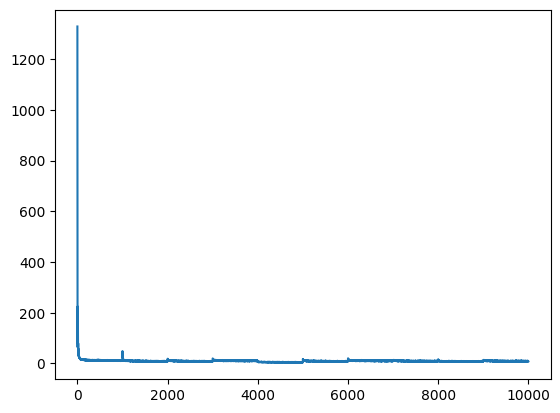

In [ ]:
plt.plot(losses)

In [11]:
states = [x.state for x in memories]

  0%|          | 0/10000 [00:00<?, ?it/s]

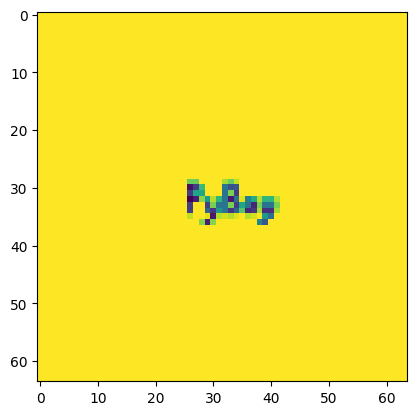

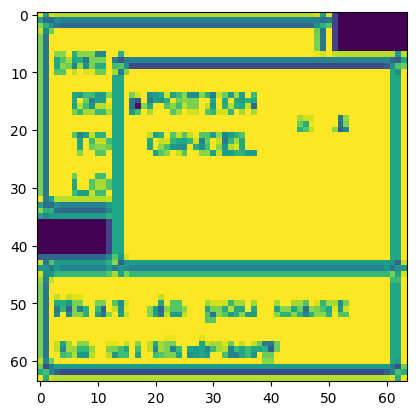

 10%|█         | 1002/10000 [00:00<00:01, 5788.00it/s]

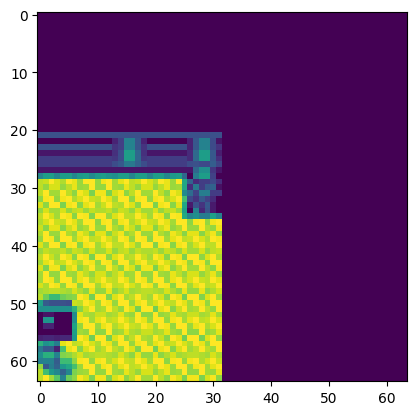

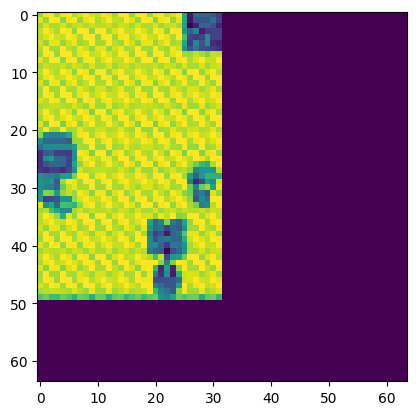

 30%|███       | 3002/10000 [00:00<00:00, 9323.99it/s]

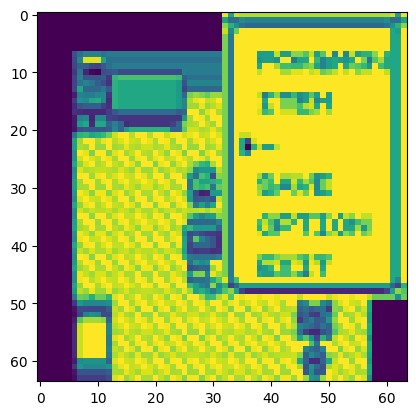

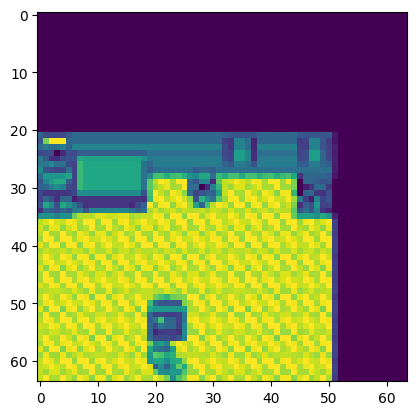

 50%|█████     | 5002/10000 [00:00<00:00, 10076.14it/s]

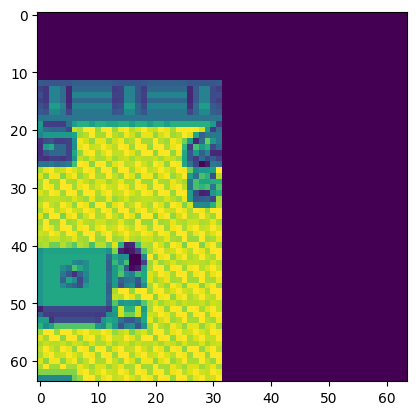

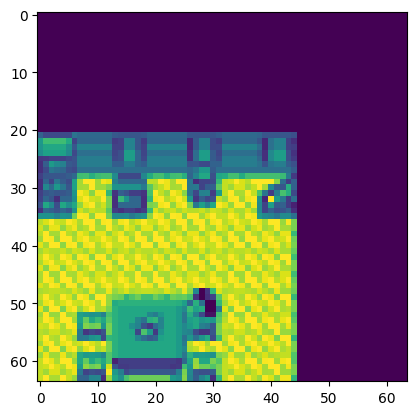

 70%|███████   | 7002/10000 [00:00<00:00, 10610.36it/s]

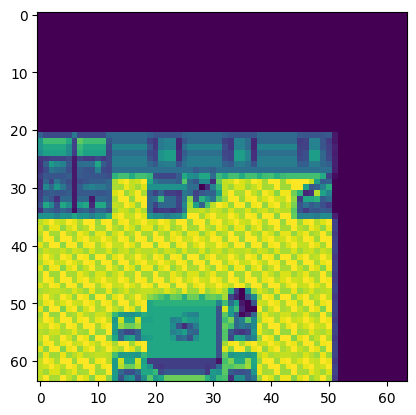

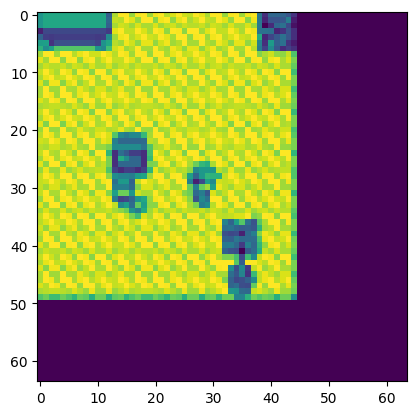

100%|██████████| 10000/10000 [00:00<00:00, 11370.58it/s]


In [13]:
for i, state in enumerate(tqdm(states)):
    if i%1000 == 1:
        screen = torch.split(state, [4096, 8], dim=1)
        plt.imshow(screen[0].view(64, 64).cpu().detach().numpy())
        plt.show()